# Library import

In [1]:
# 필요 library들을 import합니다.
import os
from typing import Tuple, Any, Callable, List, Optional, Union

import cv2
import timm
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image
from functions.functions import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model Training

In [2]:
# 학습에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정.
traindata_dir = "./data/train"    # "./data/train"
traindata_info_file = "./data/train.csv"
save_result_path = "./train_result"

In [4]:
cd ..

/data/ephemeral/home/cv20-proj1/level1-imageclassification-cv-20/suyoung


In [5]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
train_info = pd.read_csv(traindata_info_file)

In [6]:
# 총 class의 수를 측정.
num_classes = len(train_info['target'].unique())

# 각 class별로 8:2의 비율이 되도록 학습과 검증 데이터를 분리.
train_df, val_df = train_test_split(
    train_info, 
    test_size=0.2,
    stratify=train_info['target'],
    random_state=20
)

In [14]:
import os
import shutil

source_dir = '/data/ephemeral/home/cv20-proj1/level1-imageclassification-cv-20/suyoung/data/canny'  # 원본 디렉토리 경로
destination_dir = '/data/ephemeral/home/cv20-proj1/level1-imageclassification-cv-20/suyoung/data/train'  # 대상 디렉토리 경로

source_folders = os.listdir(source_dir)
destination_folders = os.listdir(destination_dir)

for i in range(len(destination_folders)):
    if destination_folders[i] in source_folders:
        folder = destination_folders[i]
        # source_images_path = os.path.join(source_dir, folder)
        # source_images_list = os.listdir(source_images_path)
        image_path_list = train_df[train_df['class_name'] == folder]['image_path'].to_list()
        for j in range(len(image_path_list)):
            source_file_path = os.path.join(source_dir, image_path_list[j])
            file_name = image_path_list[j].split('/')[-1]
            new_name = 'edge_detected_' + file_name
            destination_file_path = os.path.join(destination_dir, folder, new_name)
            shutil.copy2(source_file_path, destination_file_path)
        
        # for j in range(len(source_images_list)):
        #     source_file = source_images_list[j]
        #     source_file_path = os.path.join(source_images_path, source_file)
        #     new_name = 'edge_detected_' + source_file
        #     destination_file_path = os.path.join(destination_dir, folder, new_name)
        #     shutil.copy2(source_file_path, destination_file_path)

    else:
        print(i, destination_folders[i])

172 .DS_Store


In [15]:
# edge 내용 추가
# 1단계 : train -> 클래스 폴더별로 class_name과 target 추출
class_name_list = []
image_path_list = []
target_list = []

traindata_folders = os.listdir(traindata_dir)

for i in range(len(traindata_folders)):
    if traindata_folders[i] != '.DS_Store':
        class_name = traindata_folders[i]
        class_path = os.path.join(traindata_dir, class_name)
        class_target = train_info[train_info['class_name'] == class_name]['target'].unique().item()

        # 클래스 폴더에서 이미지별로 path 추출
        class_images_list = os.listdir(class_path)
        for j in range(len(class_images_list)):
            class_image = class_images_list[j]
            if class_image.startswith('edge_detected'):
                class_image_path = os.path.join(class_name, class_image)
                class_name_list.append(class_name)
                image_path_list.append(class_image_path)
                target_list.append(class_target)

# 데이터 프레임에 추가하기 
new_data = pd.DataFrame({train_info.columns[0] : class_name_list, 
                         train_info.columns[1] : image_path_list,
                         train_info.columns[2] : target_list})

train_info = pd.concat([train_info, new_data], ignore_index=True)
train_info = train_info.astype({'target' : 'int'})
train_info

,class_name,image_path,target
0,n01872401,n01872401/sketch_50.JPEG,59
1,n02417914,n02417914/sketch_11.JPEG,202
2,n02106166,n02106166/sketch_3.JPEG,138
3,n04235860,n04235860/sketch_2.JPEG,382
4,n02056570,n02056570/sketch_40.JPEG,80
...,...,...,...
27032,n03188531,n03188531/edge_detected_sketch_45.JPEG,272
27033,n03188531,n03188531/edge_detected_sketch_13.JPEG,272
27034,n03188531,n03188531/edge_detected_sketch_15.JPEG,272
27035,n03188531,n03188531/edge_detected_sketch_30.JPEG,272


In [16]:
# 학습에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "torchvision"
)
train_transform = transform_selector.get_transform(is_train=True)
val_transform = transform_selector.get_transform(is_train=False)

# 학습에 사용할 Dataset을 선언.
train_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=train_df,
    transform=train_transform
)
val_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=val_df,
    transform=val_transform
)

# 학습에 사용할 DataLoader를 선언.
train_loader = DataLoader(
    train_dataset, 
    batch_size=128, 
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=128, 
    shuffle=False
)

In [17]:
# 학습에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm', 
    num_classes=num_classes,
    model_name='convnext_base', 
    pretrained=True
)
model = model_selector.get_model()

# 선언된 모델을 학습에 사용할 장비로 셋팅.
model.to(device)

TimmModel(
  (model): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=512, out_features=128, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_dw):

In [18]:
# 학습에 사용할 optimizer를 선언하고, learning rate를 지정
optimizer = optim.Adam(
    model.parameters(), 
    lr=0.0003
)

In [19]:
# 스케줄러 초기화
scheduler_step_size = 2  # 매 30step마다 학습률 감소
scheduler_gamma = 0.5  # 학습률을 현재의 10%로 감소

# 한 epoch당 step 수 계산
steps_per_epoch = len(train_loader)

# 2 epoch마다 학습률을 감소시키는 스케줄러 선언
epochs_per_lr_decay = 2
scheduler_step_size = steps_per_epoch * epochs_per_lr_decay

scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=scheduler_step_size, 
    gamma=scheduler_gamma
)

In [20]:
# 학습에 사용할 Loss를 선언.
loss_fn = Loss()

In [21]:
# 앞서 선언한 필요 class와 변수들을 조합해, 학습을 진행할 Trainer를 선언. 
trainer = Trainer(
    model=model, 
    device=device, 
    train_loader=train_loader,
    val_loader=val_loader, 
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn, 
    epochs=50,
    result_path=save_result_path
)

Epoch 1/50


Epoch 1, Train Loss: 2.8143, Train Accuracy: 0.5234
Epoch 1, Validation Loss: 0.8661, Validation Accuracy: 0.7840

Save 0epoch result. Loss = 0.8661
Lowest loss updated to 0.8661. Early stop counter reset to 0.


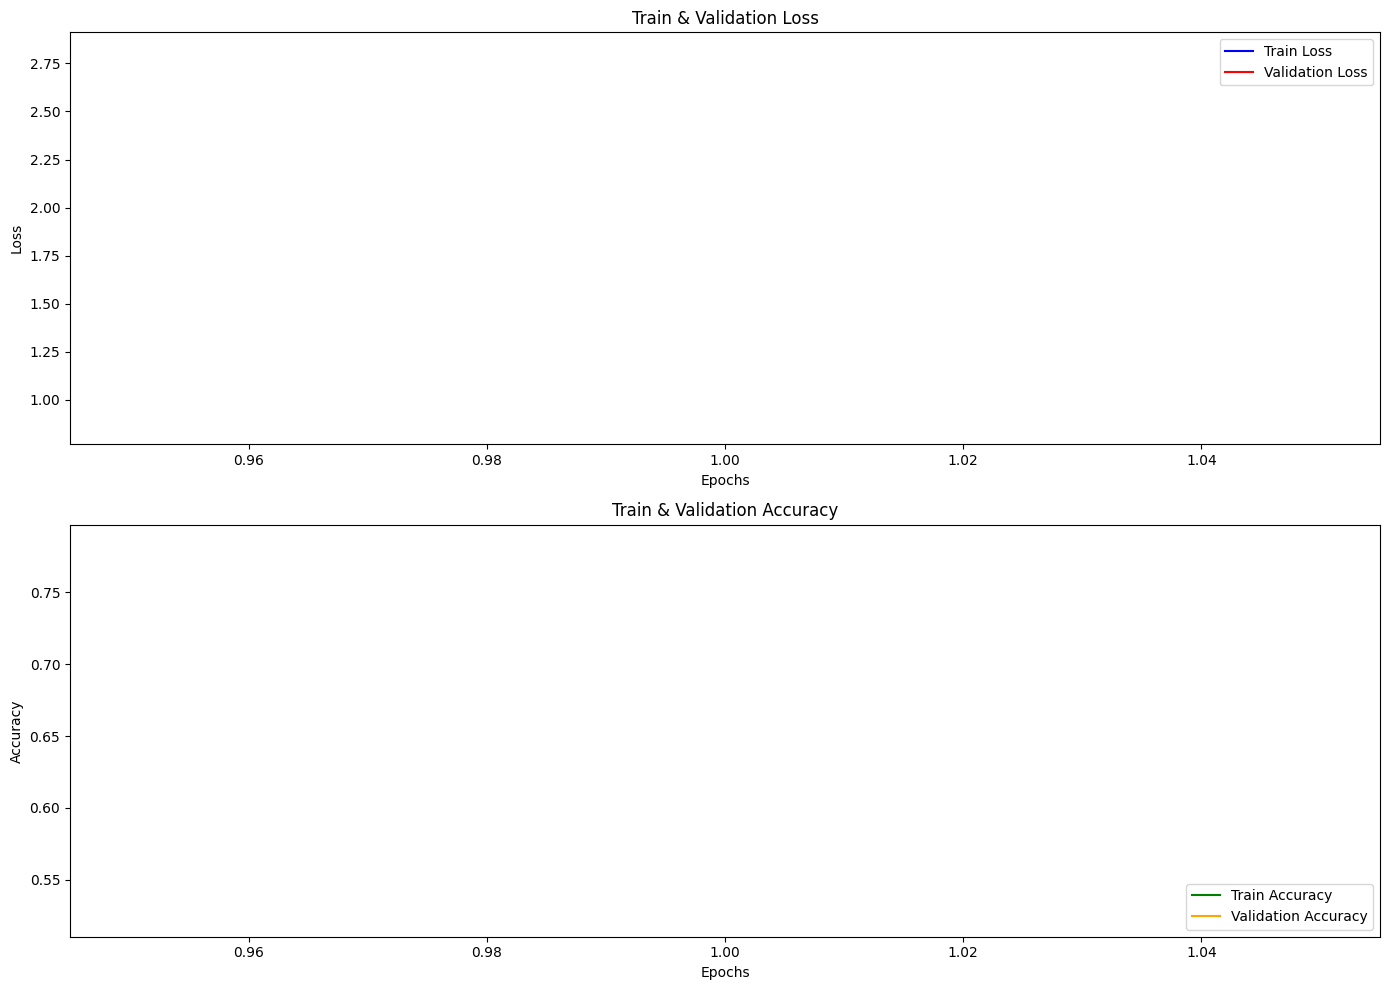

Epoch 2/50


Epoch 2, Train Loss: 0.4701, Train Accuracy: 0.8738
Epoch 2, Validation Loss: 0.6170, Validation Accuracy: 0.8359

Save 1epoch result. Loss = 0.6170
Lowest loss updated to 0.6170. Early stop counter reset to 0.


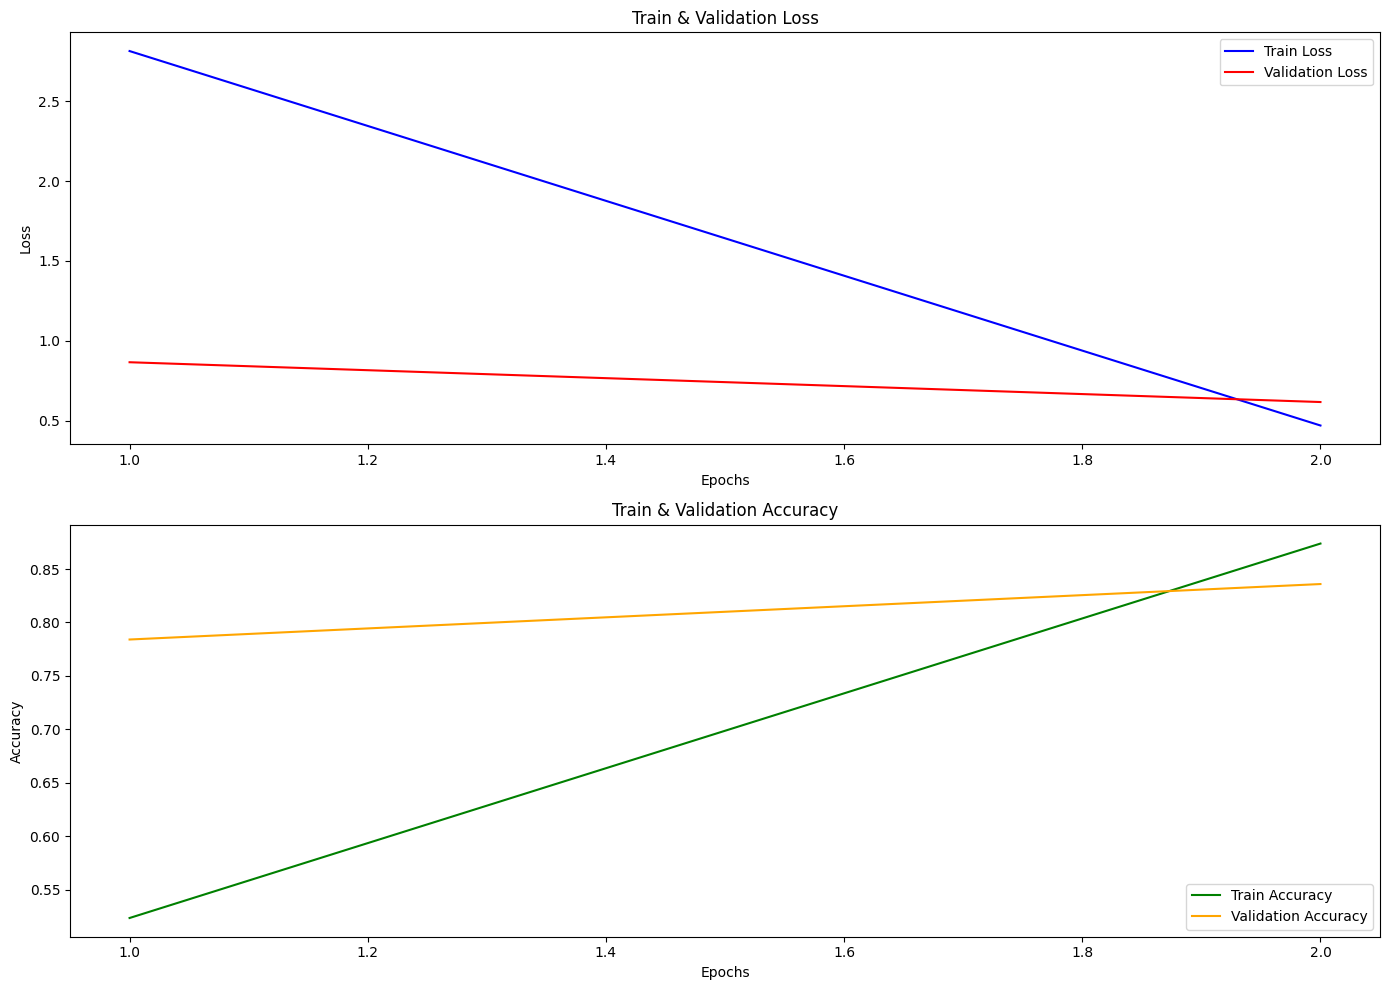

Epoch 3/50


Epoch 3, Train Loss: 0.2146, Train Accuracy: 0.9394
Epoch 3, Validation Loss: 0.5373, Validation Accuracy: 0.8616

Save 2epoch result. Loss = 0.5373
Lowest loss updated to 0.5373. Early stop counter reset to 0.


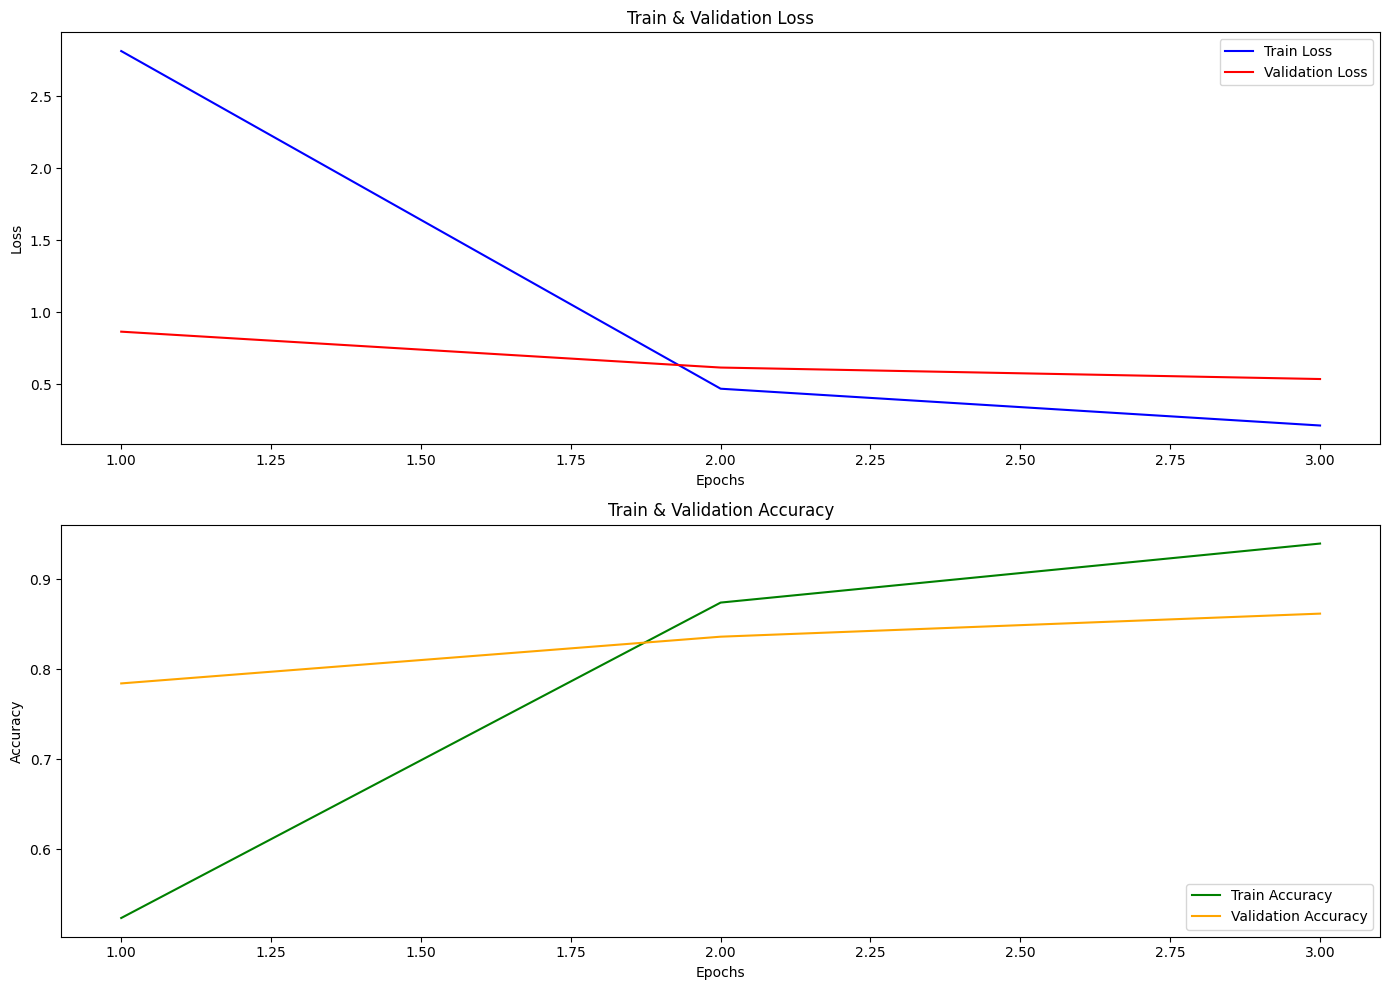

Epoch 4/50


Epoch 4, Train Loss: 0.1398, Train Accuracy: 0.9593
Epoch 4, Validation Loss: 0.4853, Validation Accuracy: 0.8649

Save 3epoch result. Loss = 0.4853
Lowest loss updated to 0.4853. Early stop counter reset to 0.


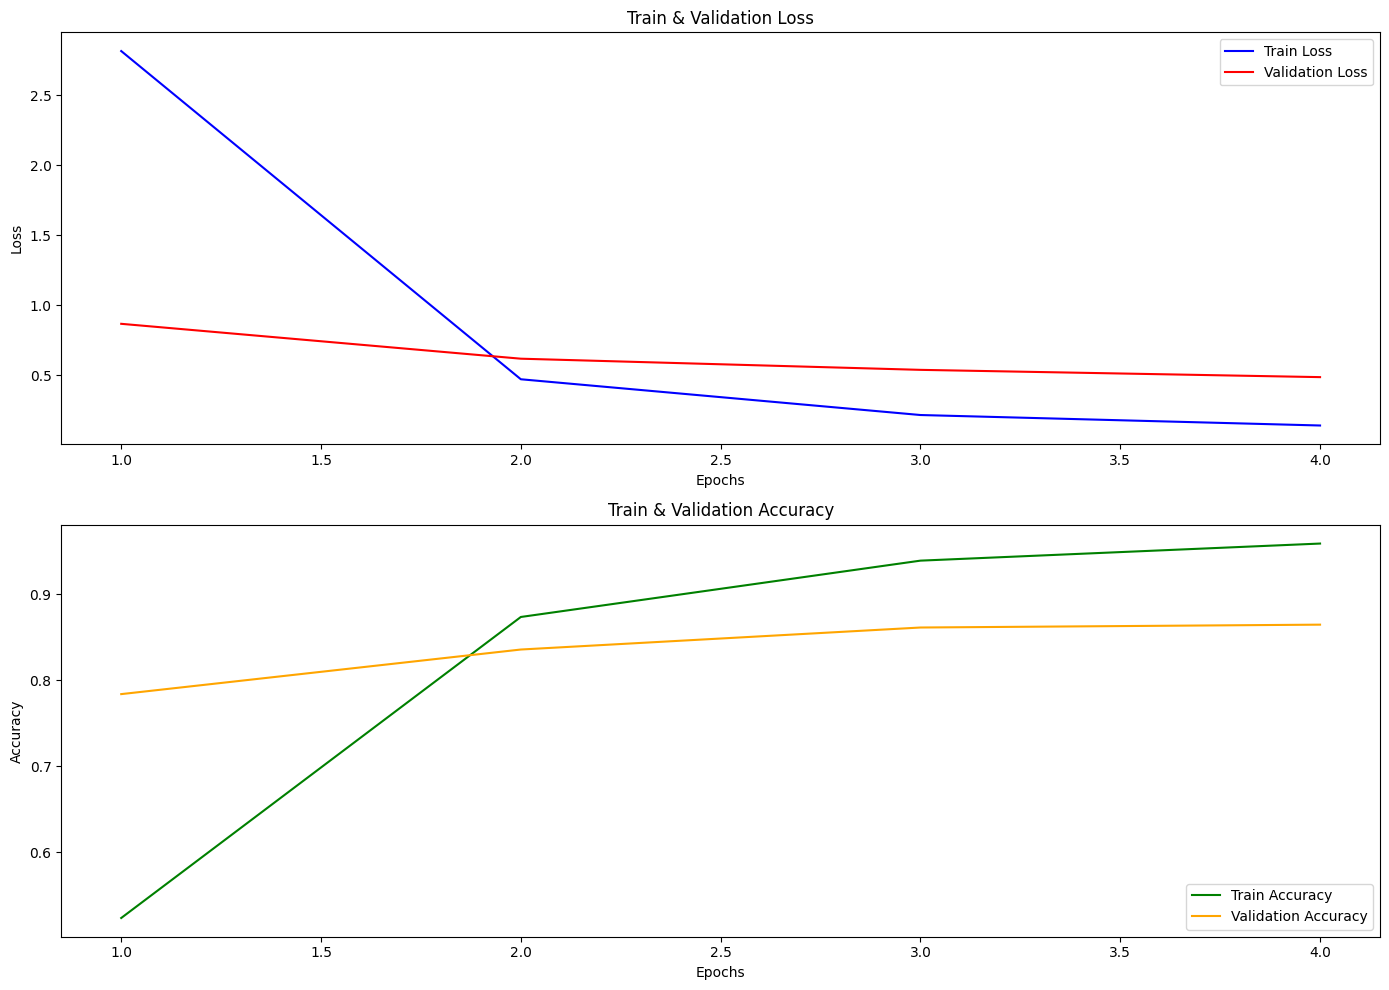

Epoch 5/50


Epoch 5, Train Loss: 0.0951, Train Accuracy: 0.9740
Epoch 5, Validation Loss: 0.4749, Validation Accuracy: 0.8775

Save 4epoch result. Loss = 0.4749
Lowest loss updated to 0.4749. Early stop counter reset to 0.


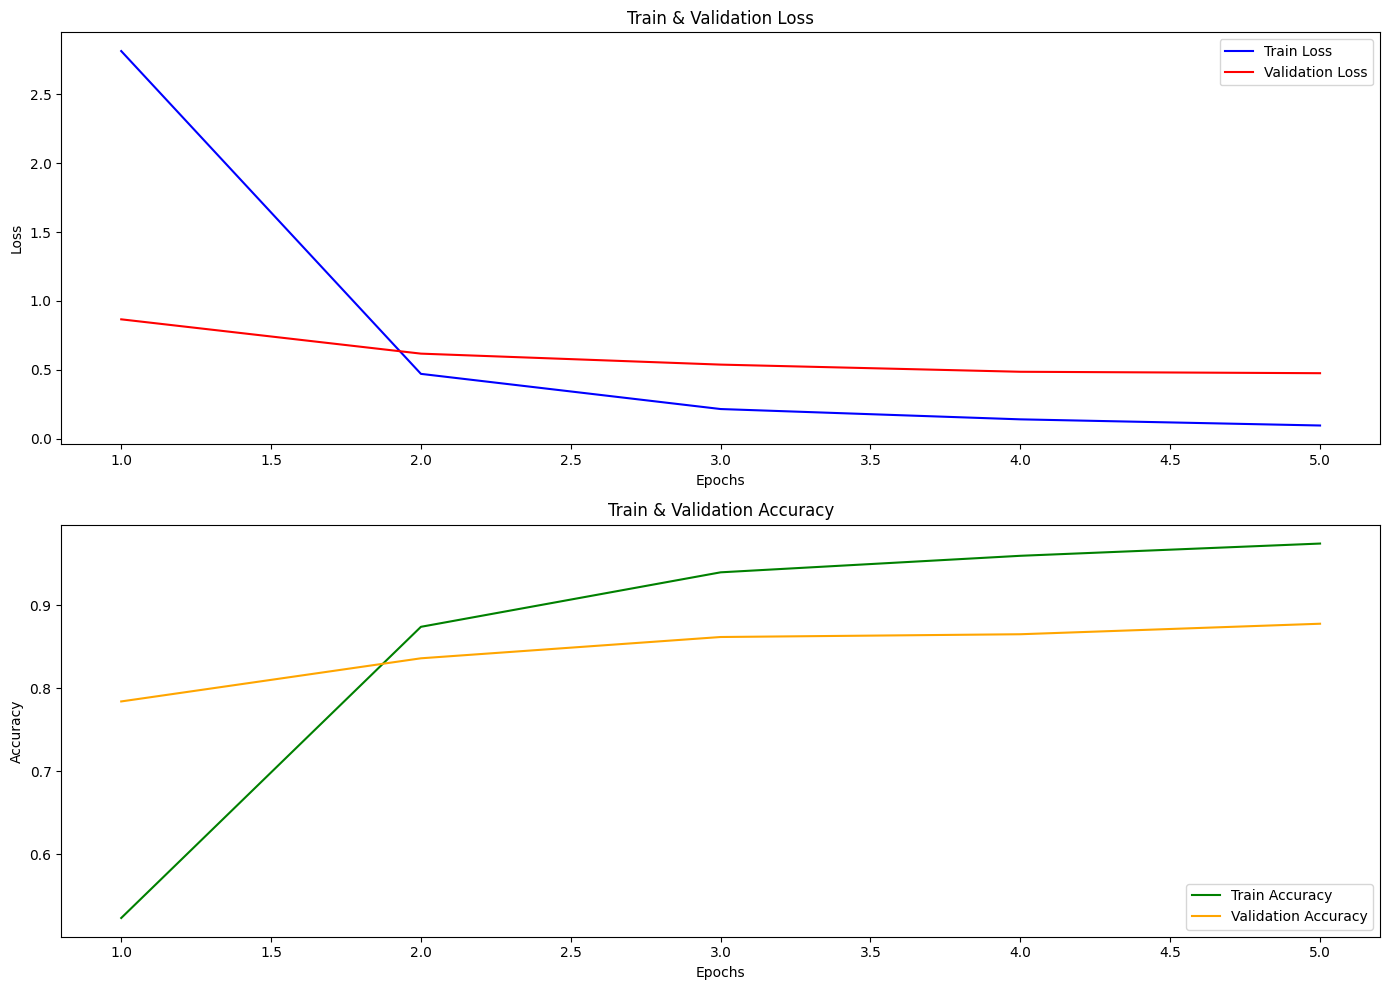

Epoch 6/50


Epoch 6, Train Loss: 0.0755, Train Accuracy: 0.9789
Epoch 6, Validation Loss: 0.4976, Validation Accuracy: 0.8689



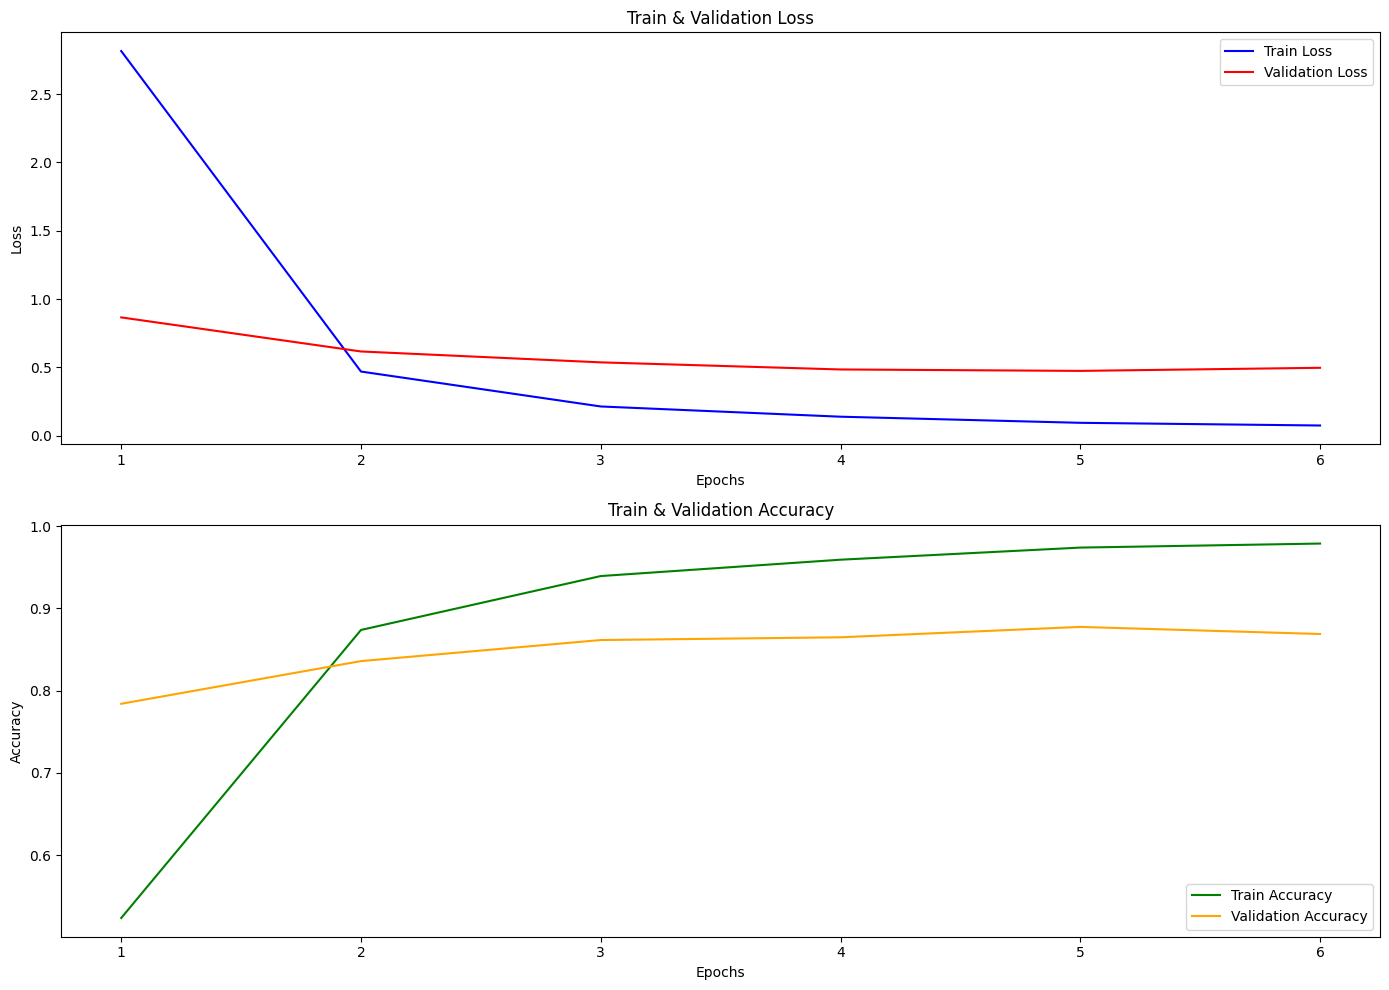

Epoch 7/50


Epoch 7, Train Loss: 0.0549, Train Accuracy: 0.9856
Epoch 7, Validation Loss: 0.4825, Validation Accuracy: 0.8765



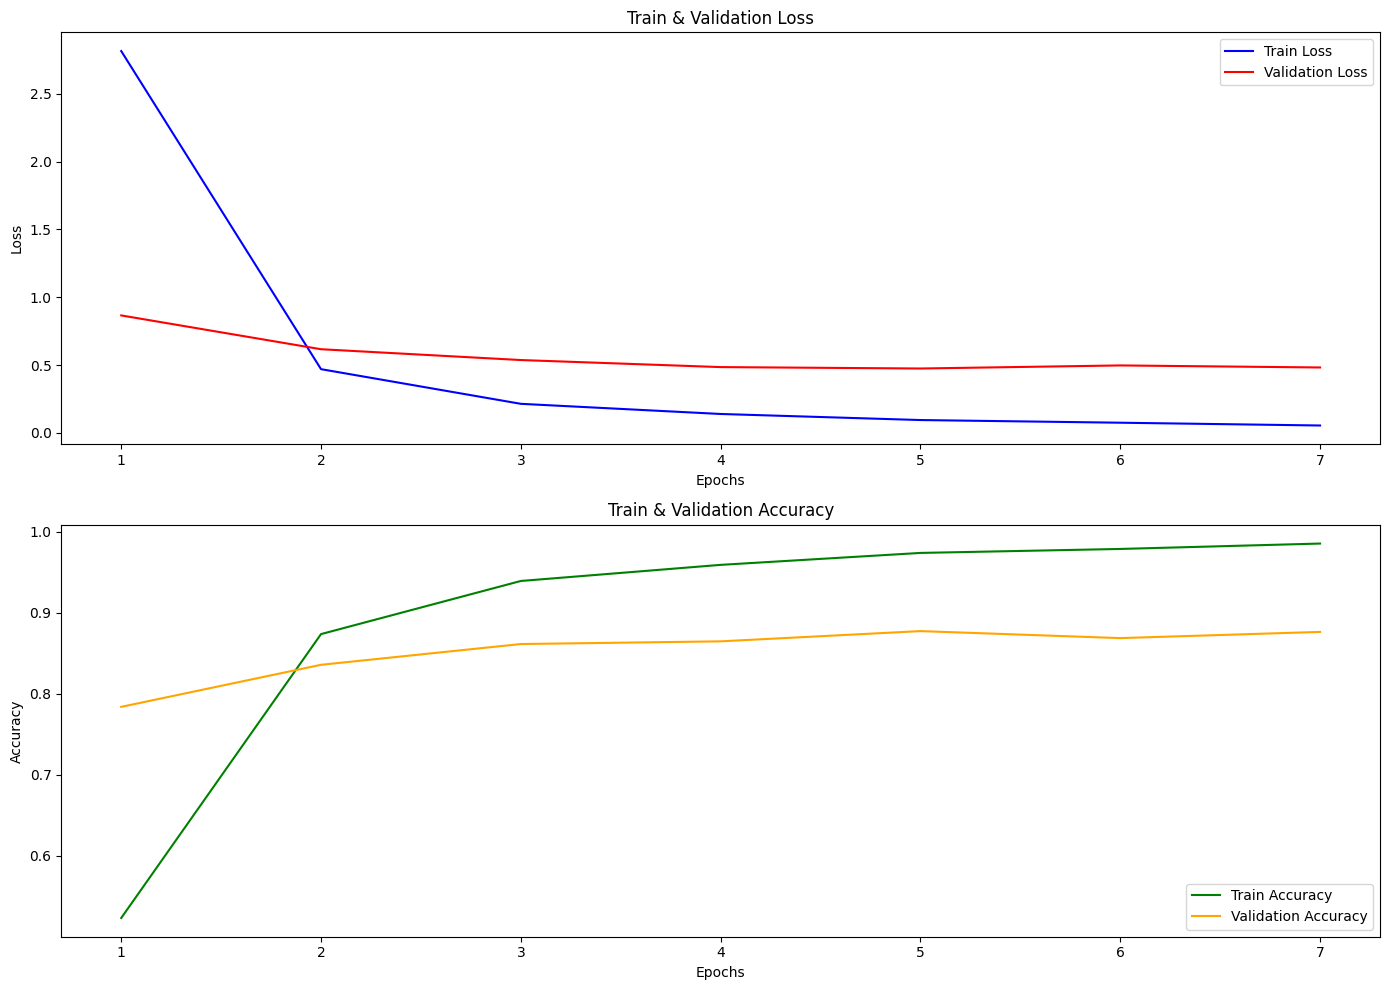

Epoch 8/50


Epoch 8, Train Loss: 0.0566, Train Accuracy: 0.9829
Epoch 8, Validation Loss: 0.5264, Validation Accuracy: 0.8702



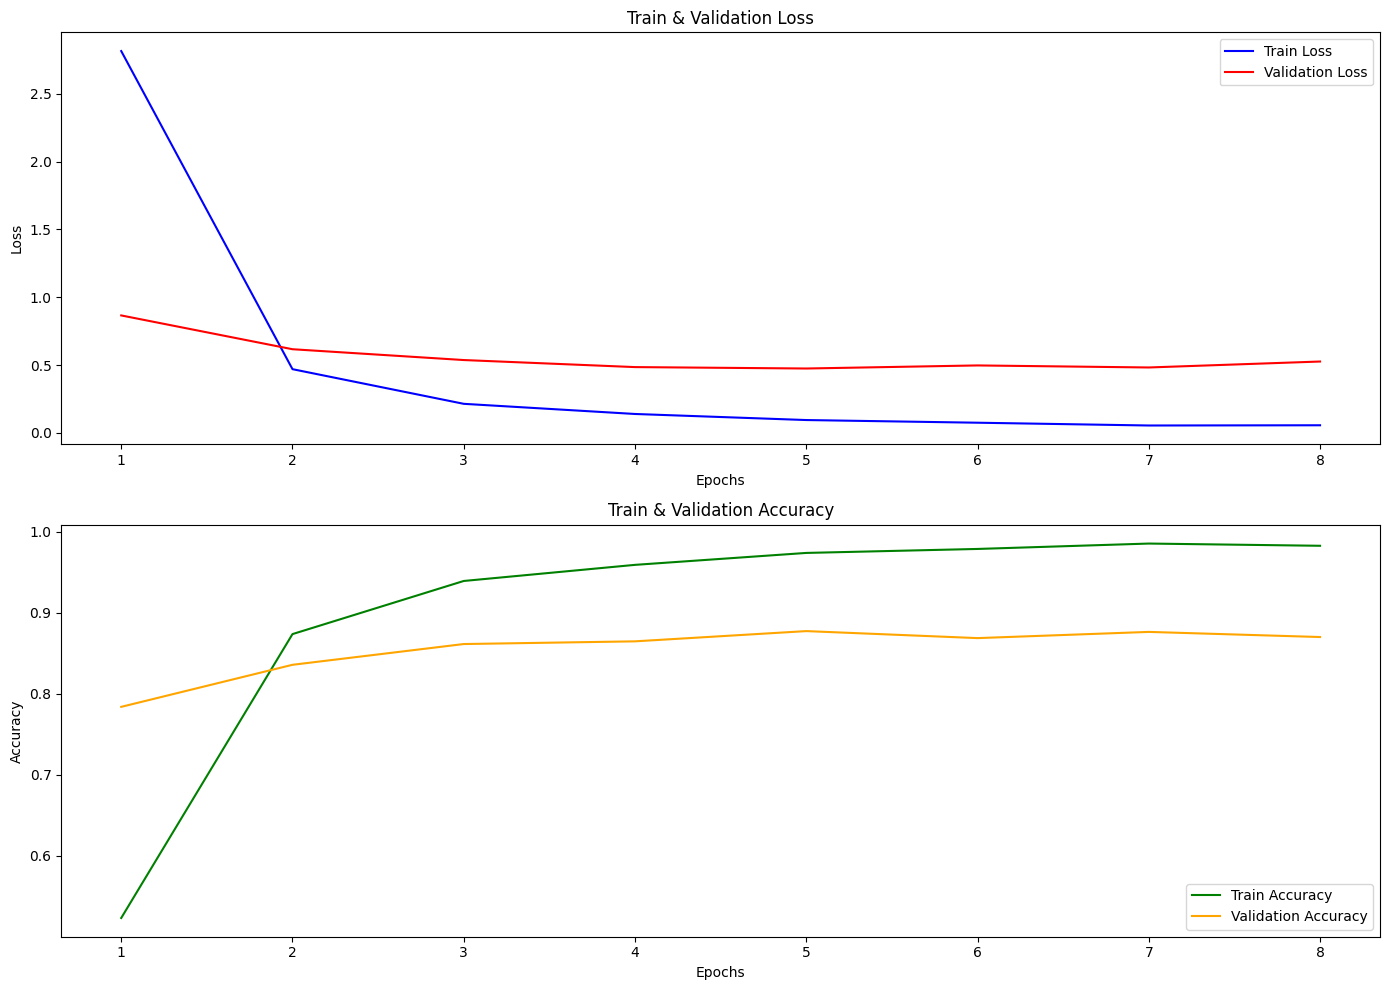

Epoch 9/50


Epoch 9, Train Loss: 0.0623, Train Accuracy: 0.9817
Epoch 9, Validation Loss: 0.5263, Validation Accuracy: 0.8769



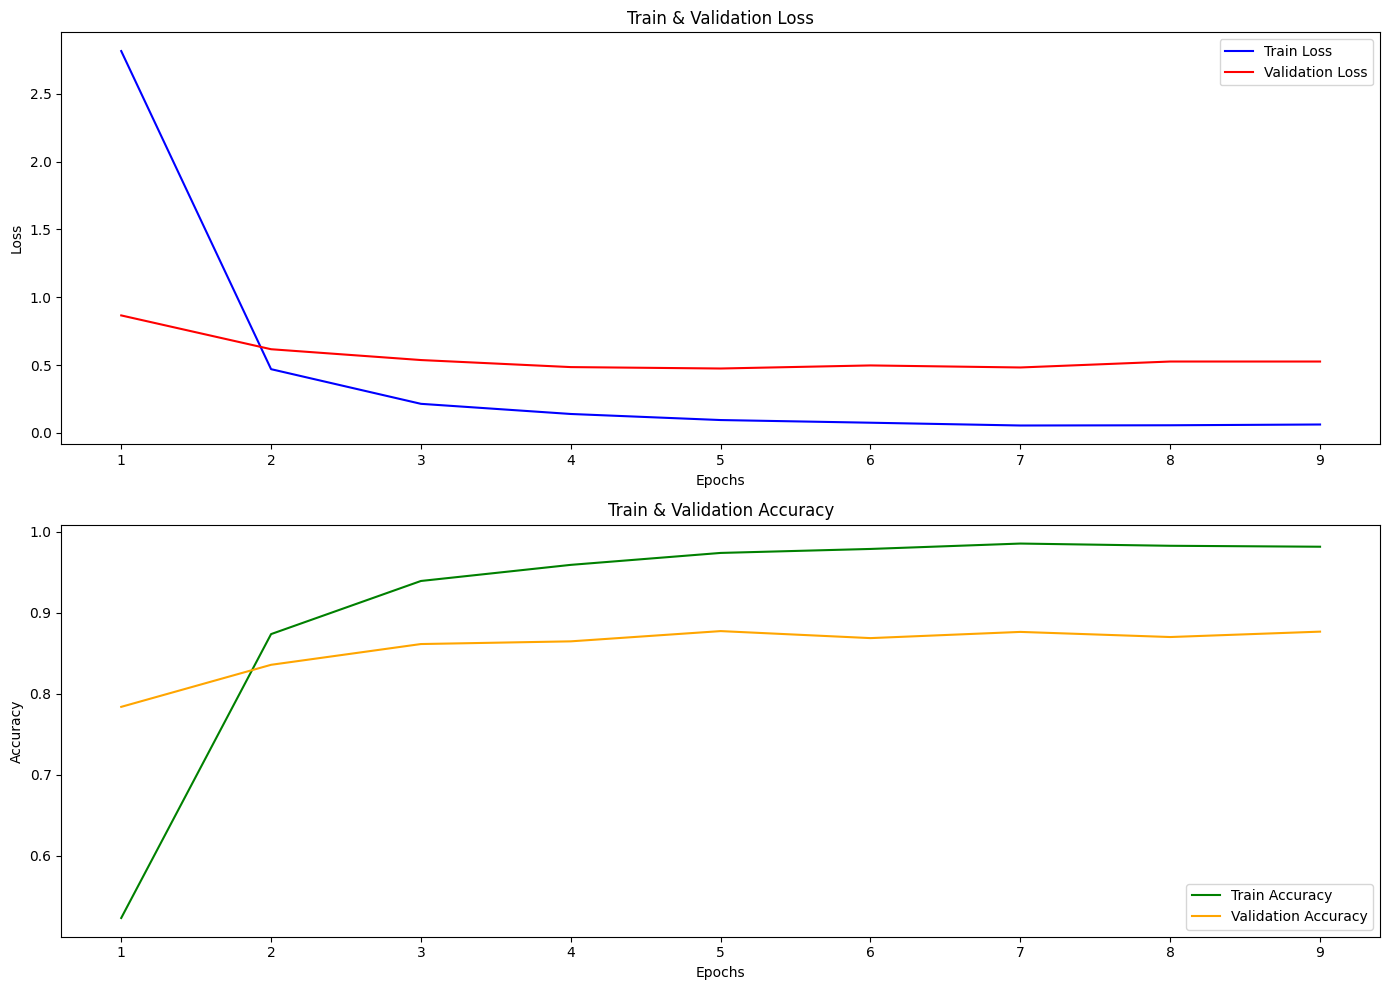

Epoch 10/50


Epoch 10, Train Loss: 0.0677, Train Accuracy: 0.9800
Epoch 10, Validation Loss: 0.6134, Validation Accuracy: 0.8499

Early stopping at epoch 10.


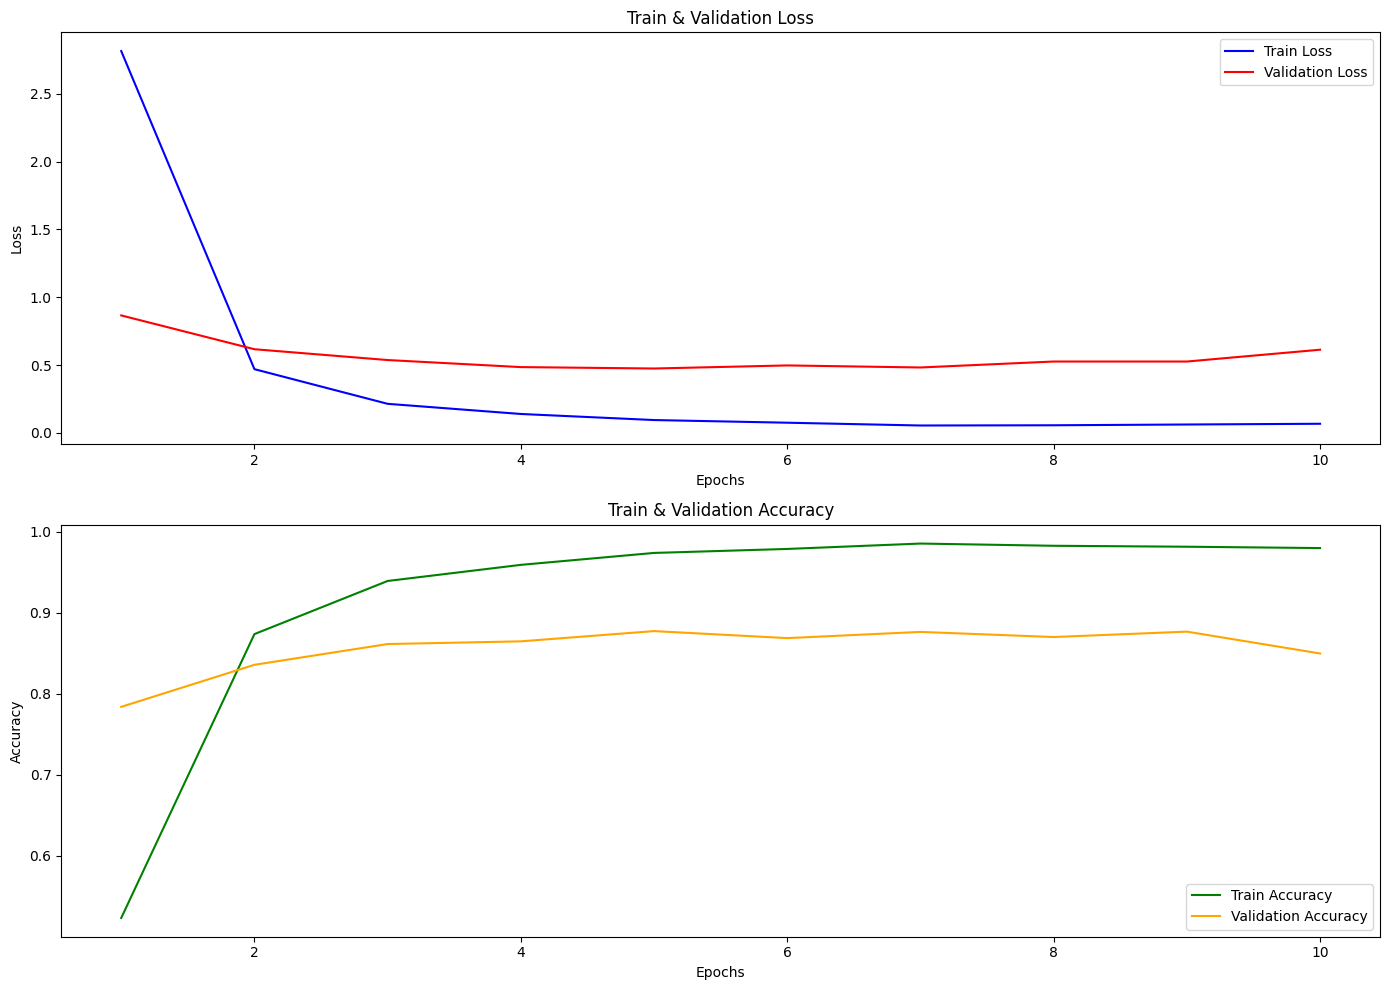

In [22]:
# 모델 학습.
trainer.train()

# Inference

In [24]:
# 모델 추론을 위한 함수
def inference(
    model: nn.Module, 
    device: torch.device, 
    test_loader: DataLoader
):
    # 모델을 평가 모드로 설정
    model.to(device)
    model.eval()
    
    predictions = []
    with torch.no_grad():  # Gradient 계산을 비활성화
        for images in tqdm(test_loader):
            # 데이터를 같은 장치로 이동
            images = images.to(device)
            
            # 모델을 통해 예측 수행
            logits = model(images)
            logits = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
            
            # 예측 결과 저장
            predictions.extend(preds.cpu().detach().numpy())  # 결과를 CPU로 옮기고 리스트에 추가
    
    return predictions

In [25]:
# 추론 데이터의 경로와 정보를 가진 파일의 경로를 설정.
testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"
save_result_path = "./train_result"

In [26]:
# 추론 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
test_info = pd.read_csv(testdata_info_file)

# 총 class 수.
num_classes = 500

In [27]:
# 추론에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "torchvision"
)
test_transform = transform_selector.get_transform(is_train=False)

# 추론에 사용할 Dataset을 선언.
test_dataset = CustomDataset(
    root_dir=testdata_dir,
    info_df=test_info,
    transform=test_transform,
    is_inference=True
)

# 추론에 사용할 DataLoader를 선언.
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False,
    drop_last=False
)

In [34]:
# 추론에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 추론에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm', 
    num_classes=num_classes,
    model_name='convnext_base', 
    pretrained=False
)
model = model_selector.get_model()


In [35]:
# best epoch 모델을 불러오기.
model.load_state_dict(
    torch.load(
        os.path.join(save_result_path, "best_model.pt"),
        map_location='cpu'
    )
)

<All keys matched successfully>

In [36]:
# predictions를 CSV에 저장할 때 형식을 맞춰서 저장
# 테스트 함수 호출
predictions = inference(
    model=model, 
    device=device, 
    test_loader=test_loader
)

100%|██████████| 157/157 [02:05<00:00,  1.25it/s]


In [37]:
# 모든 클래스에 대한 예측 결과를 하나의 문자열로 합침
test_info['target'] = predictions
test_info = test_info.reset_index().rename(columns={"index": "ID"})
test_info

,ID,ID,image_path,target
0,0,0,0.JPEG,328
1,1,1,1.JPEG,414
2,2,2,2.JPEG,493
3,3,3,3.JPEG,17
4,4,4,4.JPEG,388
...,...,...,...,...
10009,10009,10009,10009.JPEG,235
10010,10010,10010,10010.JPEG,111
10011,10011,10011,10011.JPEG,466
10012,10012,10012,10012.JPEG,400


In [38]:
# DataFrame 저장
test_info.to_csv("output101.csv", index=False)